In [1]:
# ==== 1. Import thư viện cần thiết ====
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
import graphviz

# Tên file dữ liệu và tên file model sẽ lưu
DATA_FILE = "DecisionTree_ID3_data.csv"
MODEL_FILE = "decision_tree_id3_pipeline.joblib"
TARGET_ENCODER_FILE = "target_encoder.joblib"


In [2]:
# ==== 2. Load toàn bộ dữ liệu ====
df = pd.read_csv(DATA_FILE)

print(f"Đã load thành công {len(df)} dòng dữ liệu từ file {DATA_FILE}.")
print("-" * 50)


Đã load thành công 14 dòng dữ liệu từ file DecisionTree_ID3_data.csv.
--------------------------------------------------


In [3]:
# ==== 3. Phân tách Features (X) và Target (y) ====
target_col = "Play"
y = df[target_col]

# Loại bỏ cột 'Day' và cột mục tiêu khỏi Features
feature_cols = df.drop(columns=["Day", target_col]).columns
X = df[feature_cols]

# Xác định các cột phân loại (categorical)
cat_cols = X.select_dtypes(include=['object']).columns

# Mã hóa mục tiêu (Play: Yes/No) sang số nguyên (0, 1)
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

In [4]:
# ==== 4. Định nghĩa Pipeline Tiền xử lý (ColumnTransformer) ====
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

In [5]:
# ==== 5. Xây dựng Pipeline hoàn chỉnh (Preprocessor + Model) ====
# criterion="entropy" TƯƠNG ĐƯƠNG VỚI ID3
model_id3 = DecisionTreeClassifier(criterion="entropy", random_state=42)

# Tạo Pipeline tổng hợp (tất cả logic tiền xử lý và mô hình)
pipe_id3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_id3)
])

In [6]:
# ==== 6. Chia tập train/test và Huấn luyện mô hình ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

print(f"Kích thước tập Train: {len(X_train)} mẫu")
print(f"Kích thước tập Test: {len(X_test)} mẫu")

pipe_id3.fit(X_train, y_train)

Kích thước tập Train: 9 mẫu
Kích thước tập Test: 5 mẫu


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Outlook', 'Temp', 'Humidity', 'Wind'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])

In [7]:
# ==== 7. Đánh giá mô hình ====
y_pred = pipe_id3.predict(X_test)
y_test_labels = target_encoder.inverse_transform(y_test)
y_pred_labels = target_encoder.inverse_transform(y_pred)

print("\n" + "="*20 + " KẾT QUẢ ĐÁNH GIÁ " + "="*20)
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))
print("="*58)


==================== KẾT QUẢ ĐÁNH GIÁ ====================
Accuracy: 0.6

Classification Report:
               precision    recall  f1-score   support

          No       0.00      0.00      0.00         1
         Yes       0.75      0.75      0.75         4

    accuracy                           0.60         5
   macro avg       0.38      0.38      0.38         5
weighted avg       0.60      0.60      0.60         5


Confusion Matrix:
 [[0 1]
 [1 3]]


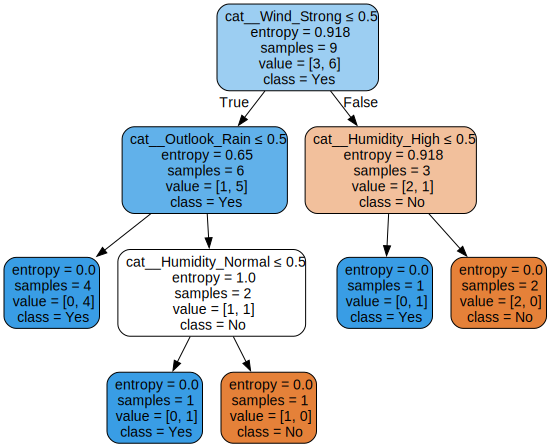

In [10]:
# ==== 8. Xuất hình cây quyết định (Sử dụng tên Feature sau OHE) ====
# Lấy các tên feature đã được OHE từ preprocessor
from sklearn.tree import export_graphviz
import os
os.environ["PATH"] += os.pathsep + r"E:\Program\Graphviz\bin"


ohe_feature_names = pipe_id3.named_steps['preprocessor'].get_feature_names_out()

dot_data = export_graphviz(
    pipe_id3.named_steps['classifier'],
    out_file=None,
    feature_names=ohe_feature_names,
    class_names=target_encoder.classes_,
    filled=True,
    rounded=True,
    special_characters=True,
    impurity=True
)

graph = graphviz.Source(dot_data)
# graph.render("decision_tree_id3_pipeline", format="png", cleanup=True)
# print(f"Ảnh cây quyết định đã được xuất → decision_tree_id3_pipeline.png")

from IPython.display import display
display(graph)

In [ ]:
# ==== 8. Lưu model Pipeline và Encoder ====
joblib.dump(pipe_id3, MODEL_FILE)
joblib.dump(target_encoder, TARGET_ENCODER_FILE) 

print(f"\nPipeline model đã được lưu thành công → {MODEL_FILE}")
print(f"Target Encoder đã được lưu thành công → {TARGET_ENCODER_FILE}")